# Whole set

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
metadata_path = "/mnt/d/projects/VSP-LLM/data/processed/vasr/metadata.parquet"
metadata_df = pd.read_parquet(metadata_path)
metadata_df.loc[:, "sent_len"] = metadata_df["transcript"].apply(lambda x: len(x.split()))
metadata_df

,id,shard,split,fps,sampling_rate,transcript,video_num_frames,audio_num_frames,sent_len
0,0070925,001,valid,25,16000,thành ra ở giêng nó vẫn hỏi hay hơn vậy thì mì...,76,48000,18
1,0063053,001,valid,25,16000,một á là chúng ta sẽ sử dụng da mi trên để mà ...,76,48000,17
2,0076991,001,valid,25,16000,là những đôi mắt có những cái độ xập xệ những ...,76,48000,15
3,0123846,001,train,25,16000,họ phải là nó chuẩn ai cũng sợ hết,76,48000,9
4,0063937,001,valid,25,16000,thì mình phải chọn một người đàn ông thật là t...,76,48000,18
...,...,...,...,...,...,...,...,...,...
1254381,0220647,200,train,25,16000,tử tế niềm vui và hạnh phúc đến với,76,48000,9
1254382,0220804,200,train,25,16000,hoài là không có ai quan tâm đến bạn ngoài anh ta,76,48000,12
1254383,0194363,200,train,25,16000,làm mẹ nhưng vẫn chưa được ở ngoài ấy rất nhiều,76,48000,11
1254384,0139143,200,train,25,16000,đang kết kỉnh giống như ở trên trang đứa phân ...,76,48000,11


## Number of samples

In [2]:
def visualize_num_samples(df: pd.DataFrame, split: str = "all") -> int:
    if split == "all":
        return df.shape[0]
    return df[df["split"] == split].shape[0]

split = "valid"
duration = 3
num_samples = visualize_num_samples(metadata_df, split)
print(f"Number of samples in {split}: {num_samples}")
print(f"Amount of hours in {split}: {int(num_samples * duration / 3600)}")

Number of samples in valid: 23990
Amount of hours in valid: 19


## Sentence length

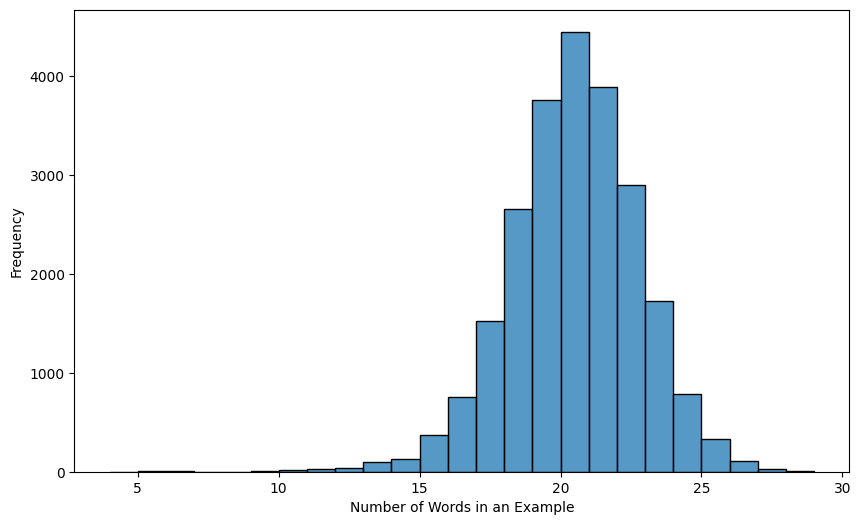

Max sequence length: 29
Min sequence length: 4
Average sequence length: 19.984079264936273
Median sequence length: 20.0


In [6]:
def visualize_sent_len(df: pd.DataFrame, split: str = "all"):
    split_df = df if split == "all" else df[df["split"] == split]
    sequence_lengths = split_df["sent_len"].tolist()
    split = split.capitalize() + " set" if split != "all" else "Dataset"
    plt.figure(figsize=(10, 6))
    sns.histplot(sequence_lengths, bins=list(set(sequence_lengths)), kde=False)
    plt.xlabel('Number of Words in an Example')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Max sequence length: {split_df['sent_len'].max()}")
    print(f"Min sequence length: {split_df['sent_len'].min()}")
    print(f"Average sequence length: {split_df['sent_len'].mean()}")
    print(f"Median sequence length: {split_df['sent_len'].median()}")

split = "test"
visualize_sent_len(metadata_df, split)

## Vocabulary

In [4]:
vocabs = dict()
vocabs_per_split = dict()
for sample in metadata_df.itertuples():
    for word in sample.transcript.split():
        vocabs[word] = vocabs.get(word, 0) + 1
        vocabs_per_split[(word, sample.split)] = vocabs_per_split.get((word, sample.split), 0) + 1
vocab_df = pd.DataFrame(vocabs.items(), columns=["word", "frequency"])
vocab_df = vocab_df.sort_values("frequency", ascending=False)
vocab_per_split_df = pd.DataFrame(
    [(k[0], k[1], v) for k, v in vocabs_per_split.items()],
    columns=["word", "split", "frequency"],
)

In [5]:
vocab_df

,word,frequency
18,là,585991
37,cái,382031
36,có,316103
11,mình,266532
10,thì,264906
...,...,...
6914,yêm,1
6915,são,1
6926,đỉ,1
6928,chõ,1


In [6]:
vocab_per_split_df

,word,split,frequency
0,thành,valid,551
1,ra,valid,1805
2,ở,valid,1511
3,giêng,valid,1
4,nó,valid,6961
...,...,...,...
15135,ht,train,1
15136,tậptrung,train,1
15137,phặng,train,1
15138,vão,train,1


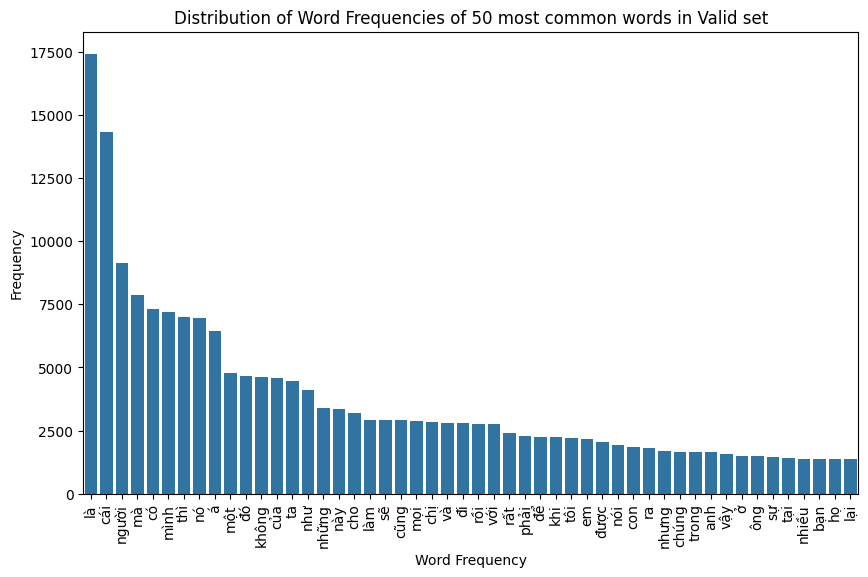

Number of unique words in valid: 3704


In [7]:
def visualize_vocabs(vocab_df: pd.DataFrame, vocab_per_split_df: pd.DataFrame, split: str = "all"):
    vocab_df = vocab_df if split == "all" else vocab_per_split_df[vocab_per_split_df["split"] == split][["word", "frequency"]]
    vocab_df = vocab_df.sort_values("frequency", ascending=False)

    num_words = 50
    set_name = split.capitalize() + " set" if split != "all" else "Dataset"
    plt.figure(figsize=(10, 6))
    sns.barplot(y=vocab_df.head(num_words)["frequency"], x=vocab_df.head(num_words)["word"])
    plt.title(f'Distribution of Word Frequencies of {num_words} most common words in {set_name}')
    plt.xlabel('Word Frequency')
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.show()

    print(f"Number of unique words in {split}: {len(vocab_df)}")
    
    file_name = "vocabs" if split == "all" else f"{split}_vocabs"
    vocab_df.sort_values("word").to_csv(f"/mnt/d/projects/VSP-LLM/data/processed/vasr/{file_name}.csv", index=False)


split = "valid"
visualize_vocabs(vocab_df, vocab_per_split_df, split)

In [8]:
split = "train"
unique_vocab_df = vocab_per_split_df.drop_duplicates(subset=["word"], keep=False)
len(unique_vocab_df[unique_vocab_df["split"] == split])

2947

# Subset

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
num_hour = 100
data_dir = "/mnt/d/projects/VSP-LLM/data/processed/vasr"
subset_dir = os.path.join(data_dir, f"{num_hour}h")
sent_path = os.path.join(subset_dir, "train.wrd")
with open(sent_path, "r") as f:
    sents = f.readlines()
sent_df = pd.DataFrame(sents, columns=["transcript"])
sent_df.loc[:, "sent_len"] = sent_df["transcript"].apply(lambda x: len(x.split()))
sent_df

,transcript,sent_len
0,cần họ bạn sẽ sẵn sàng phơi bày những cái bộ m...,16
1,luôn nói chung là kể ra thì con gái ai cũng cả...,20
2,nhưng mà một cái cực kỳ trộm vía đấy là không ...,14
3,còn cái niềng răng trong suốt này nó giúp mình...,18
4,trong cái hội bạn của mình thì có một cái em n...,17
...,...,...
120681,hoặc là em qua đó nha có thể là bên khâu tổ ch...,15
120682,hồi nhỏ cách đây hai chục năm ổn mà có ba ngàn...,15
120683,thì thì lúc nào mình đang phân tích\n,8
120684,nếu trường hợp các bạn không tức toán cái nợ n...,14


## Sentence length

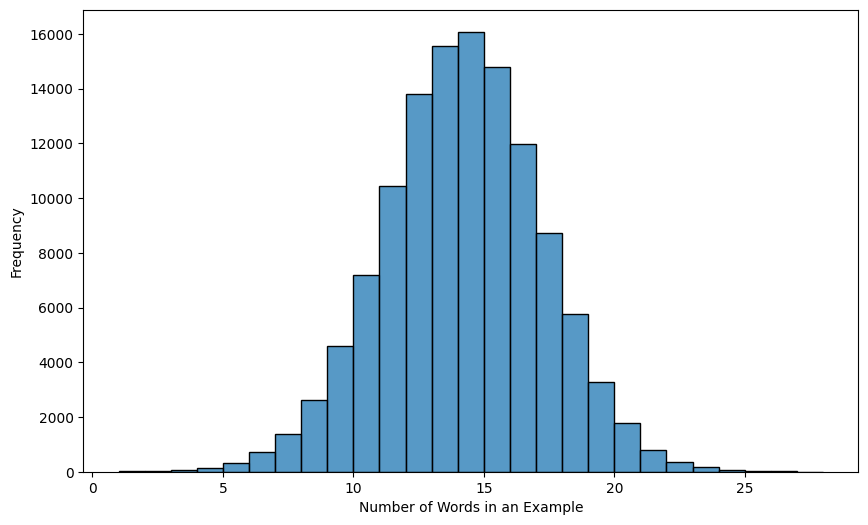

Max sequence length: 28
Min sequence length: 1
Average sequence length: 13.693120991664319
Median sequence length: 14.0


In [4]:
def visualize_sent_len(df: pd.DataFrame):
    sequence_lengths = df["sent_len"].tolist()
    plt.figure(figsize=(10, 6))
    sns.histplot(sequence_lengths, bins=list(set(sequence_lengths)), kde=False)
    plt.xlabel('Number of Words in an Example')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Max sequence length: {sent_df['sent_len'].max()}")
    print(f"Min sequence length: {sent_df['sent_len'].min()}")
    print(f"Average sequence length: {sent_df['sent_len'].mean()}")
    print(f"Median sequence length: {sent_df['sent_len'].median()}")

visualize_sent_len(sent_df)

## Vocabulary

In [11]:
subset_vocabs = dict()
for sample in sent_df.itertuples():
    for word in sample.transcript.split():
        subset_vocabs[word] = subset_vocabs.get(word, 0) + 1
subset_vocab_df = pd.DataFrame(subset_vocabs.items(), columns=["word", "frequency"])
subset_vocab_df = subset_vocab_df.sort_values("frequency", ascending=False)
subset_vocab_df

,word,frequency
50,là,110056
8,cái,71353
15,có,59953
12,mình,49844
59,thì,49524
...,...,...
5527,nọt,1
5528,xoẹt,1
5534,thuổng,1
5535,dạc,1


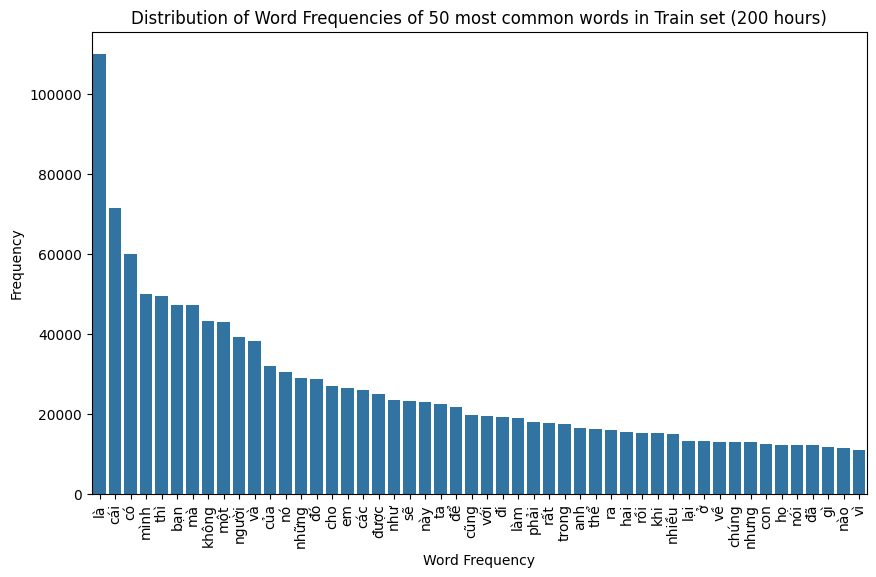

Number of unique words in train: 6369


In [12]:
def visualize_vocabs(vocab_df: pd.DataFrame):
    vocab_df = vocab_df.sort_values("frequency", ascending=False)

    num_words = 50
    plt.figure(figsize=(10, 6))
    sns.barplot(y=vocab_df.head(num_words)["frequency"], x=vocab_df.head(num_words)["word"])
    plt.title(f'Distribution of Word Frequencies of {num_words} most common words in Train set ({num_hour} hours)')
    plt.xlabel('Word Frequency')
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.show()

    print(f"Number of unique words in {split}: {len(vocab_df)}")
    
    vocab_df.sort_values("word").to_csv(f"/mnt/d/projects/VSP-LLM/data/processed/vasr/train-{num_hour}h_vocab.csv", index=False)


visualize_vocabs(subset_vocab_df)